<a href="https://colab.research.google.com/github/DrakeData/House_Price_EDA/blob/sandbox/MSDS422_Assignment_2_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - House Prices: Advanced Regression Techniques

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from numpy import array
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Lasso

%matplotlib inline
sns.set()

## Ingest

### Import Data
'train_clean.csv' and 'test_clean.csv' is the cleaned up trained data set that worked on in Assignment 1.

In [2]:
df_train = pd.read_csv('./drive/MyDrive/Colab Notebooks/House_Price_EDA/data/train_clean.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSqft,TotalBath,HouseAge,ReModeled
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,2566,3.5,5,0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,0,1262,0,1,2,0,3,1,TA,6,Typ,1,3,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500,2524,2.5,31,0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,3,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,2706,3.5,7,1
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,4,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000,2473,2.0,91,1
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,3,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000,3343,3.5,8,0


In [3]:
df_test = pd.read_csv('./drive/MyDrive/Colab Notebooks/House_Price_EDA/data/test_clean.csv')
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSqft,TotalBath,HouseAge,ReModeled
0,1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,0,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,None,MnPrv,None,0,6,2010,WD,Normal,1778.0,1.0,49,0
1,1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,0,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,None,None,Gar2,12500,6,2010,WD,Normal,2658.0,1.5,52,0
2,1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,3,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,None,MnPrv,None,0,3,2010,WD,Normal,2557.0,2.5,13,1
3,1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,4,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,None,None,None,0,6,2010,WD,Normal,2530.0,2.5,12,0
4,1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,0,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,None,None,None,0,1,2010,WD,Normal,2560.0,2.0,18,0


## EDA

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 85 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1458 non-null   int64  
 1   MSSubClass     1458 non-null   int64  
 2   MSZoning       1458 non-null   object 
 3   LotFrontage    1458 non-null   float64
 4   LotArea        1458 non-null   int64  
 5   Street         1458 non-null   object 
 6   Alley          1458 non-null   object 
 7   LotShape       1458 non-null   object 
 8   LandContour    1458 non-null   object 
 9   Utilities      1458 non-null   object 
 10  LotConfig      1458 non-null   object 
 11  LandSlope      1458 non-null   object 
 12  Neighborhood   1458 non-null   object 
 13  Condition1     1458 non-null   object 
 14  Condition2     1458 non-null   object 
 15  BldgType       1458 non-null   object 
 16  HouseStyle     1458 non-null   object 
 17  OverallQual    1458 non-null   int64  
 18  OverallC

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 84 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

### Prep the data for analysis
Filter data to look at significant features and remove the features with a correlation score greater than 0.5 with SalePrice

In [6]:
corr_mat = df_train.corr()
corr_mat['SalePrice'][(corr_mat["SalePrice"] > 0.50)]

OverallQual     0.795774
YearBuilt       0.523608
YearRemodAdd    0.507717
TotalBsmtSF     0.651153
1stFlrSF        0.631530
GrLivArea       0.734968
FullBath        0.562165
TotRmsAbvGrd    0.537769
FireplaceQu     0.521144
GarageYrBlt     0.508719
GarageCars      0.641047
GarageArea      0.629217
SalePrice       1.000000
TotalSqft       0.832877
TotalBath       0.635896
Name: SalePrice, dtype: float64

In [7]:
important_num_cols = list(corr_mat['SalePrice'][(corr_mat["SalePrice"] > 0.5)].index)

important_num_cols.remove('SalePrice')
len(important_num_cols)
print(important_num_cols)

['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'TotalSqft', 'TotalBath']


In [8]:
x_num_only = df_train[important_num_cols]
x_num_only.shape

(1458, 14)

Look at the features that are highly correlated with each other and drop them from our analysis.
We do this so to remove the 'noise' from our data as it will impact our regression model by feeding it the same information.

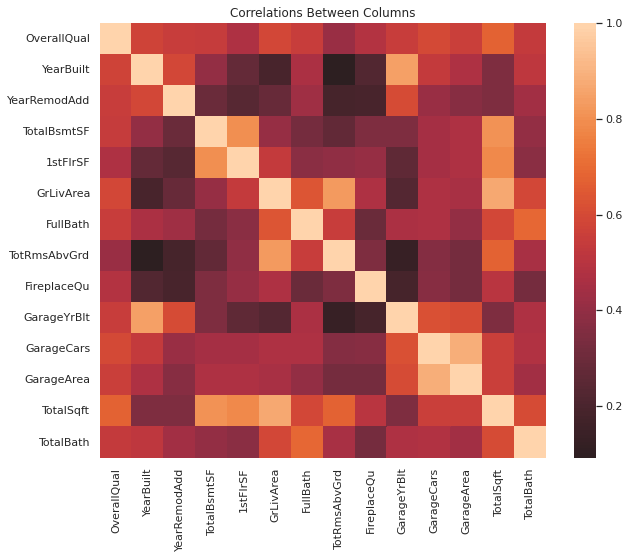

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(x_num_only.corr(), center = 0)
plt.title("Correlations Between Columns")
plt.show()

In [10]:
corr_x = x_num_only.corr()

for i in range(0, len(corr_x) - 1):
    for j in range(i + 1, len(corr_x)):
        if(corr_x.iloc[i, j] < -0.6 or corr_x.iloc[i, j] > 0.6):
            print(f"corr: {corr_x.iloc[i, j]}, row: {i}, column: {j}; {corr_x.index[i]}, {corr_x.index[j]}")

corr: 0.6007408233586187, row: 0, column: 10; OverallQual, GarageCars
corr: 0.677324662815223, row: 0, column: 12; OverallQual, TotalSqft
corr: 0.8448398583188299, row: 1, column: 9; YearBuilt, GarageYrBlt
corr: 0.6036359426335961, row: 2, column: 9; YearRemodAdd, GarageYrBlt
corr: 0.8038296279256137, row: 3, column: 4; TotalBsmtSF, 1stFlrSF
corr: 0.8063997413782675, row: 3, column: 12; TotalBsmtSF, TotalSqft
corr: 0.7819168108101032, row: 4, column: 12; 1stFlrSF, TotalSqft
corr: 0.6383784637415114, row: 5, column: 6; GrLivArea, FullBath
corr: 0.8294981976715387, row: 5, column: 7; GrLivArea, TotRmsAbvGrd
corr: 0.8663861141668217, row: 5, column: 12; GrLivArea, TotalSqft
corr: 0.6932148078878521, row: 6, column: 13; FullBath, TotalBath
corr: 0.678560717489618, row: 7, column: 12; TotRmsAbvGrd, TotalSqft
corr: 0.6195177230785254, row: 9, column: 10; GarageYrBlt, GarageCars
corr: 0.6030387164134533, row: 9, column: 11; GarageYrBlt, GarageArea
corr: 0.8873044983919205, row: 10, column: 11

In [29]:
# from the information above, we want to drop '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', and 'GarageArea'
num_cols_ls = [i for i in x_num_only.columns if i not in ['1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'GarageArea']]
num_cols_ls

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 'GrLivArea',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageCars',
 'TotalSqft',
 'TotalBath']

In [12]:
# Select the important categorical features to use
cat_cols = ["MSZoning", "Utilities", "BldgType", "Heating", 
            "KitchenQual", "SaleCondition", "LandSlope"]

columns_full_ls = num_cols + cat_cols
columns_full_ls

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 'GrLivArea',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageCars',
 'TotalSqft',
 'TotalBath',
 'MSZoning',
 'Utilities',
 'BldgType',
 'Heating',
 'KitchenQual',
 'SaleCondition',
 'LandSlope']

In [13]:
# Update 'YearRemodAdd' to show how long it has been for when the house was built and when it was remodeled
# disabling the pandas warning
pd.options.mode.chained_assignment = None

df_train['YearRemodAdd'] = df_train['YearRemodAdd'] - df_train['YearBuilt']
df_test['YearRemodAdd'] = df_test['YearRemodAdd'] - df_test['YearBuilt']

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSqft,TotalBath,HouseAge,ReModeled
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,2566,3.5,5,0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,0,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,0,1262,0,1,2,0,3,1,TA,6,Typ,1,3,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500,2524,2.5,31,0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,1,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,3,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,2706,3.5,7,1
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,55,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,4,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000,2473,2.0,91,1
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,3,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000,3343,3.5,8,0


In [22]:
df_train_final = df_train
df_test_final = df_test

df_train_final.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSqft,TotalBath,HouseAge,ReModeled
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856.0,GasA,...,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,0,Attchd,2003.0,RFn,2.0,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,2566.0,3.5,5,0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,0,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262.0,GasA,...,0,1262,0,1,2,0,3,1,TA,6,Typ,1,3,Attchd,1976.0,RFn,2.0,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500,2524.0,2.5,31,0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,1,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920.0,GasA,...,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,3,Attchd,2001.0,RFn,2.0,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,2706.0,3.5,7,1
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,55,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756.0,GasA,...,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,4,Detchd,1998.0,Unf,3.0,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000,2473.0,2.0,91,1
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145.0,GasA,...,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,3,Attchd,2000.0,RFn,3.0,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000,3343.0,3.5,8,0


In [23]:
for col in columns_full_ls:
    train = sorted(df_train_final[col].unique().tolist())
    test = sorted(df_test_final[col].unique().tolist())
    total = set(train + test)
    df_train_final[col] = pd.Categorical(df_train_final[col], categories=total)
    df_test_final[col] = pd.Categorical(df_test_final[col], categories=total)

In [24]:
df_train_final = pd.get_dummies(df_train_final, columns=cat_cols)
df_test_final = pd.get_dummies(df_test_final, columns=cat_cols)


df_train_final.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,...,MiscVal,MoSold,YrSold,SaleType,SalePrice,TotalSqft,TotalBath,HouseAge,ReModeled,MSZoning_C (all),MSZoning_FV,MSZoning_RM,MSZoning_RH,MSZoning_RL,Utilities_NoSeWa,Utilities_AllPub,BldgType_1Fam,BldgType_TwnhsE,BldgType_Duplex,BldgType_2fmCon,BldgType_Twnhs,Heating_Grav,Heating_GasW,Heating_Floor,Heating_Wall,Heating_GasA,Heating_OthW,KitchenQual_TA,KitchenQual_Fa,KitchenQual_Ex,KitchenQual_Gd,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Family,SaleCondition_Abnorml,SaleCondition_Alloca,LandSlope_Sev,LandSlope_Gtl,LandSlope_Mod
0,1,60,65.0,8450,Pave,None,Reg,Lvl,Inside,CollgCr,Norm,Norm,2Story,7,5,2003,0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856.0,Ex,Y,SBrkr,856,854,...,0,2,2008,WD,208500,2566.0,3.5,5,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,Pave,None,Reg,Lvl,FR2,Veenker,Feedr,Norm,1Story,6,8,1976,0,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262.0,Ex,Y,SBrkr,1262,0,...,0,5,2007,WD,181500,2524.0,2.5,31,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,Pave,None,IR1,Lvl,Inside,CollgCr,Norm,Norm,2Story,7,5,2001,1,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920.0,Ex,Y,SBrkr,920,866,...,0,9,2008,WD,223500,2706.0,3.5,7,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,Pave,None,IR1,Lvl,Corner,Crawfor,Norm,Norm,2Story,7,5,1915,55,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756.0,Gd,Y,SBrkr,961,756,...,0,2,2006,WD,140000,2473.0,2.0,91,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0
4,5,60,84.0,14260,Pave,None,IR1,Lvl,FR2,NoRidge,Norm,Norm,2Story,8,5,2000,0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145.0,Ex,Y,SBrkr,1145,1053,...,0,12,2008,WD,250000,3343.0,3.5,8,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0


### Split data into train and test sets

In [38]:
## Split the data into train and test set
x = df_train_final[num_cols_ls]
y = df_train_final['SalePrice']

((1093, 10), (365, 10), (1093,), (365,))

### Normalize the data

In [59]:
# Standardize the numeric columns
ss = StandardScaler()

ss_train = ss.fit_transform(x)
ss_test = ss.transform(df_test_final[num_cols_ls])

## Modeling

### Single Linear Regression
For this model, we will use the most corralated feature to SalePrice, which is OverallQual

In [66]:
ss_train1 = ss.fit_transform(x_train[['OverallQual']])
ss_test1 = ss.transform(x_test[['OverallQual']])



In [68]:
ss_train1.shape

(1458, 1)

In [69]:
ss_test1.shape

(1459, 1)

In [77]:
## Features I want to look at
f1 = ['TotalSqft']

## Run a Linear Regression looking at one feature
x1 = df_train_final[f1]
y = df_train_final['SalePrice']


x_train, x_test, y_train, y_test = train_test_split(x1, y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1093, 1), (365, 1), (1093,), (365,))

In [78]:
# Simple Linear Regression
linreg1 = LinearRegression()
kf = KFold(n_splits=7, shuffle=True)

# Standardize the numeric columns
ss = StandardScaler()

ss_train = ss.fit_transform(x_train)
ss_test = ss.transform(x_test)

scores = cross_val_score(linreg1, ss_train, y_train, cv=kf)
print(scores)
print(f'Mean Score: {scores.mean()}; SD: {scores.std()}')


linreg1.fit(ss_train, y_train)
print(f'TRAIN Score: {linreg1.score(ss_train, y_train)}')
print(f'TEST Score: {linreg1.score(ss_test, y_test)}')

pred = linreg1.predict(ss_test)
b, m = np.polynomial.polynomial.polyfit(y_test, pred, 1)

[0.72957089 0.60003005 0.64544659 0.61697354 0.70386879 0.68419032
 0.72894686]
Mean Score: 0.6727181480128807; SD: 0.04874222916049639
TRAIN Score: 0.6910288831098768
TEST Score: 0.7010116595341009


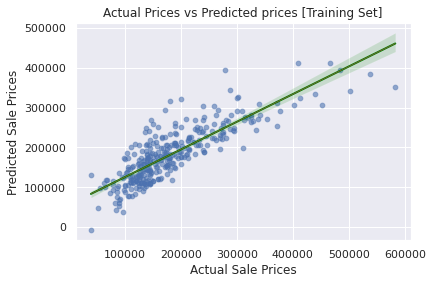

In [79]:
sns.scatterplot(x=y_test, y=pred, alpha=0.4)
sns.regplot(x=y_test, y=pred, truncate=True, scatter_kws={'s': 20, 'alpha':0.3}, 
            line_kws={'color':'green', 'linewidth': 2})
sns.lineplot(x=np.unique(y_test), y=np.unique(np.poly1d(b + m * np.unique(y_test))), linewidth=0.5, color='r')

plt.xlabel("Actual Sale Prices")
plt.ylabel("Predicted Sale Prices")
plt.title("Actual Prices vs Predicted prices [Training Set]")
 
plt.show()

### Multiple Linear Regression

In [110]:
## Features I want to llok at
f2 = num_cols_ls

## Run a Linear Regression looking at one feature
x2 = df_train_final[f2]
y = df_train_final['SalePrice']


x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y)
x2_train.shape, x2_test.shape, y2_train.shape, y2_test.shape

((1093, 10), (365, 10), (1093,), (365,))

In [111]:
# Simple Linear Regression
linreg2 = LinearRegression()
kf = KFold(n_splits=7, shuffle=True)

# Standardize the numeric columns
ss = StandardScaler()

ss_train2 = ss.fit_transform(x2_train)
ss_test2 = ss.transform(x2_test)

scores = cross_val_score(linreg2, ss_train2, y2_train, cv=kf)
print(scores)
print(f'Mean Score: {scores.mean()}; SD: {scores.std()}')


linreg2.fit(ss_train2, y2_train)
print(f'TRAIN Score: {linreg2.score(ss_train2, y2_train)}')
print(f'TEST Score: {linreg2.score(ss_test2, y2_test)}')

pred2 = linreg2.predict(ss_test2)
b, m = np.polynomial.polynomial.polyfit(y2_test, pred2, 1)

[0.84950672 0.76734479 0.82781291 0.82594812 0.83719513 0.83881085
 0.80800088]
Mean Score: 0.8220884863681043; SD: 0.025361968065302058
TRAIN Score: 0.8241909001828883
TEST Score: 0.8028016041129133


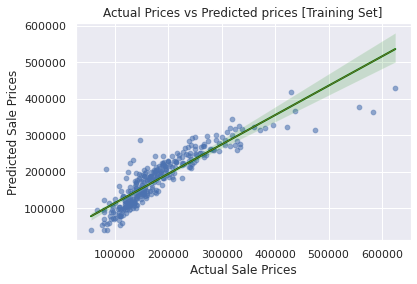

In [112]:
sns.scatterplot(x=y2_test, y=pred2, alpha=0.4)
sns.regplot(x=y2_test, y=pred2, truncate=True, scatter_kws={'s': 20, 'alpha':0.3}, 
            line_kws={'color':'green', 'linewidth': 2})
sns.lineplot(x=np.unique(y2_test), y=np.unique(np.poly1d(b + m * np.unique(y2_test))), linewidth=0.5, color='r')

plt.xlabel("Actual Sale Prices")
plt.ylabel("Predicted Sale Prices")
plt.title("Actual Prices vs Predicted prices [Training Set]")
 
plt.show()

In [113]:
holdout_df = df_test_final[num_cols_ls]

# Standardize the numeric columns
ss = StandardScaler()
ss_holdout = ss.fit_transform(holdout_df)

# predict SalePrice
predict = linreg2.predict(ss_holdout)
submit = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': predict})
submit

#export to csv
submit.to_csv('./drive/MyDrive/Colab Notebooks/House_Price_EDA/submission.csv',index=False)